In [1]:
from keras.datasets import cifar10
import keras
import cv2
import matplotlib.pyplot as plt
from keras.models import Model  
%matplotlib inline
from keras.models import Sequential,load_model
from keras.layers import Dense,Conv2D,Activation,BatchNormalization,MaxPool2D,Flatten,Input,ZeroPadding2D,MaxPooling2D,concatenate,AveragePooling2D,Dropout,GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.optimizers import SGD
import keras.callbacks as kcallbacks

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


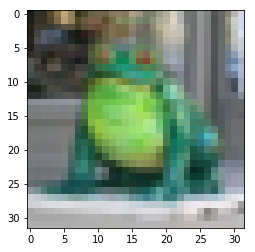

In [3]:
# 可以随机选择一个将图片数据可视化
img=X_train[19]
plt.imshow(img)

In [4]:
# 将y数据处理成one-hot编码的数据
y_train=to_categorical(y_train,num_classes=10)
y_test=to_categorical(y_test,num_classes=10)
print(y_train.shape)
print(y_test.shape)
# 将X数据进行归一化，方便训练的时候算法收敛
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train=X_train/255
X_test=X_test/255
print(X_train.shape)
print(X_test.shape)

(50000, 10)
(10000, 10)
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
# 定义一些初始化的变量
INPUT_SHAPE=(32,32,3)
NUM_CLASS=10
BATCHSIZE=128
EPOCHS=100
SAVEPATH='./'

In [6]:
def lexnet(input_shape,num_class,batchsize,epochs,savepath='./cifar10_lexnet_model.hdf5'):
    # create model
    model=Sequential()
    model.add(Conv2D(filters=6, kernel_size=(5,5), padding='valid', input_shape=input_shape, activation='tanh'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='tanh'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    #下面就是全连接层了
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(num_class, activation='softmax'))
    #定义一下优化的方法
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #compile model
    #使用交叉熵(cross entropy)作为损失函数
    model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
    )
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    model.fit(X_train,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
              validation_data=(X_test,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
   #reload model
    model=load_model(savepath)
    return model

In [7]:
lexnet_model=lexnet(INPUT_SHAPE,NUM_CLASS,BATCHSIZE,EPOCHS)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.6341 - acc: 0.4130 - val_loss: 1.4705 - val_acc: 0.4809

Epoch 00001: val_acc improved from -inf to 0.48090, saving model to ./cifar10_lexnet_model.hdf5
Epoch 2/100
50000/50000 [==============================] - 2s 48us/step - loss: 1.3711 - acc: 0.5122 - val_loss: 1.4181 - val_acc: 0.4953

Epoch 00002: val_acc improved from 0.48090 to 0.49530, saving model to ./cifar10_lexnet_model.hdf5
Epoch 3/100
50000/50000 [==============================] - 2s 48us/step - loss: 1.2805 - acc: 0.5445 - val_loss: 1.2533 - val_acc: 0.5574

Epoch 00003: val_acc improved from 0.49530 to 0.55740, saving model to ./cifar10_lexnet_model.hdf5
Epoch 4/100
50000/50000 [==============================] - 2s 50us/step - loss: 1.2083 - acc: 0.5727 - val_loss: 1.2015 - val_acc: 0.5803

Epoch 00004: val_acc improved from 0.55740 to 0.58030, saving model to ./cifar10_lexnet_model.hdf5
E

In [8]:
lexnet_model.summary()
score=lexnet_model.evaluate(X_test,y_test)
print('lexnet的评估结果是')
print("Total loss on Testing Set:", score[0])
print("Accuracy of Testing Set:", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

预测的结果是： 3
真实的结果是： 3


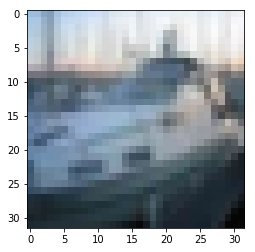

In [9]:
lexnet_model=load_model('./cifar10_lexnet_model.hdf5')
X_test_t=X_test[8].reshape((-1,32,32,3))
y_hat=lexnet_model.predict(X_test_t).argmax()
print('预测的结果是：',y_hat)
print('真实的结果是：',y_test[8].argmax())
plt.imshow(X_test[2])

In [10]:
def alexnet(input_shape,num_class,batchsize,epochs,savepath=SAVEPATH+'cifar10_alexnet_model.hdf5'):
    model = Sequential()  
    model.add(Conv2D(96,(11,11),strides=(4,4),input_shape=input_shape,padding='valid',activation='relu',kernel_initializer='uniform'))  
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
    model.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
    model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
    model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
    model.add(Flatten())  
    model.add(Dense(4096,activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(4096,activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(num_class,activation='softmax'))  
    #定义一下优化的方法
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #compile一下模型
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    model.fit(X_train,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
              validation_data=(X_test,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
    #reload model
    model=load_model(savepath)
    return model

In [11]:
alexnet_model=lexnet(INPUT_SHAPE,NUM_CLASS,BATCHSIZE,EPOCHS)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s 53us/step - loss: 1.6179 - acc: 0.4204 - val_loss: 1.4141 - val_acc: 0.4915

Epoch 00001: val_acc improved from -inf to 0.49150, saving model to ./cifar10_lexnet_model.hdf5
Epoch 2/100
50000/50000 [==============================] - 2s 49us/step - loss: 1.3499 - acc: 0.5197 - val_loss: 1.3080 - val_acc: 0.5343

Epoch 00002: val_acc improved from 0.49150 to 0.53430, saving model to ./cifar10_lexnet_model.hdf5
Epoch 3/100
50000/50000 [==============================] - 3s 51us/step - loss: 1.2499 - acc: 0.5579 - val_loss: 1.2465 - val_acc: 0.5570

Epoch 00003: val_acc improved from 0.53430 to 0.55700, saving model to ./cifar10_lexnet_model.hdf5
Epoch 4/100
50000/50000 [==============================] - 3s 52us/step - loss: 1.1785 - acc: 0.5840 - val_loss: 1.1925 - val_acc: 0.5735

Epoch 00004: val_acc improved from 0.55700 to 0.57350, saving model to ./cifar10_lexnet_model.hdf5
E

In [12]:
score=alexnet_model.evaluate(X_test,y_test)
print('alexnet_model的评估结果是')
print("Total loss on Testing Set:", score[0])
print("Accuracy of Testing Set:", score[1])

10000/10000 [==============================] - 1s 64us/step
alexnet_model的评估结果是
Total loss on Testing Set: 1.0734142539024354
Accuracy of Testing Set: 0.6315


## 接下来训练vgg网络
因为vgg网络要求输入不要太小，所以我们需要把输入数据resize成64,64,3

In [13]:
from keras.applications.vgg19 import VGG19
import numpy as np
import cv2

In [14]:
X_train_vgg=[cv2.resize(img,(64,64)) for img in X_train]
X_train_vgg=np.array(X_train_vgg)
X_test_vgg=[cv2.resize(img,(64,64)) for img in X_test]
X_test_vgg=np.array(X_test_vgg)

In [15]:
def vgg19net(input_shape,num_class,batchsize,epochs,savepath=SAVEPATH+'cifar10_vgg_model.hdf5'):
    model_vgg19=VGG19(include_top=False,weights='imagenet',input_shape=(64,64,3))
    model=Flatten(name='flatten')(model_vgg19.output)
    model=Dense(10,activation='softmax')(model)
    model_vgg19_clair=Model(model_vgg19.input,model,name='vgg19')
    #定义一下优化的方法
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #compile一下模型
    model_vgg19_clair.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    model_vgg19_clair.fit(X_train_vgg,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
              validation_data=(X_test_vgg,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
    #reload model
    vgg19_clair_model=load_model(savepath)
    return vgg19_clair_model

In [16]:
vgg_model=vgg19net((64,64,3),NUM_CLASS,BATCHSIZE,EPOCHS)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 76s 2ms/step - loss: 2.0941 - acc: 0.1859 - val_loss: 1.7908 - val_acc: 0.2843

Epoch 00001: val_acc improved from -inf to 0.28430, saving model to ./cifar10_vgg_model.hdf5
Epoch 2/100
50000/50000 [==============================] - 75s 2ms/step - loss: 1.6751 - acc: 0.3522 - val_loss: 1.4098 - val_acc: 0.4645

Epoch 00002: val_acc improved from 0.28430 to 0.46450, saving model to ./cifar10_vgg_model.hdf5
Epoch 3/100
50000/50000 [==============================] - 79s 2ms/step - loss: 1.3100 - acc: 0.5158 - val_loss: 1.1945 - val_acc: 0.5570

Epoch 00003: val_acc improved from 0.46450 to 0.55700, saving model to ./cifar10_vgg_model.hdf5
Epoch 4/100
50000/50000 [==============================] - 77s 2ms/step - loss: 1.0722 - acc: 0.6087 - val_loss: 0.9738 - val_acc: 0.6488

Epoch 00004: val_acc improved from 0.55700 to 0.64880, saving model to ./cifar10_vgg_model.hdf5
Epoch 5/100
5

In [17]:
score=vgg_model.evaluate(X_test_vgg,y_test)
print('vgg_model的评估结果是')
print("Total loss on Testing Set:", score[0])
print("Accuracy of Testing Set:", score[1])

10000/10000 [==============================] - 7s 707us/step
vgg_model的评估结果是
Total loss on Testing Set: 0.6523544511795044
Accuracy of Testing Set: 0.8042


## 接下来是google的inceptionv3
输入采取的是139,139,3

In [18]:
from keras.applications.inception_v3 import InceptionV3
import numpy as np
X_train_inception=[cv2.resize(img,(139,139)) for img in X_train]
X_train_inception=np.array(X_train_inception)
X_test_inception=[cv2.resize(img,(139,139)) for img in X_test]
X_test_inception=np.array(X_test_inception)

In [19]:
print(X_train_inception.shape)

(50000, 139, 139, 3)


In [20]:
def inceptionv3(input_shape,num_class,batchsize,epochs,savepath=SAVEPATH+'inceptionv3.hdf5'):
    base_model=InceptionV3(include_top=False,weights='imagenet',input_shape=input_shape)
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 10classes
    predictions = Dense(num_class, activation='softmax')(x)
    model=Model(base_model.input,predictions,name='inceptionv3')
    #定义一下优化的方法
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #compile一下模型
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    model.fit(X_train_inception,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
              validation_data=(X_test_inception,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
    #reload model
    model=load_model(savepath)
    return model

In [21]:
inceptionv3_model=inceptionv3((139,139,3),NUM_CLASS,BATCHSIZE,EPOCHS)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 172s 3ms/step - loss: 0.5765 - acc: 0.8111 - val_loss: 1.1327 - val_acc: 0.6781

Epoch 00001: val_acc improved from -inf to 0.67810, saving model to ./inceptionv3.hdf5
Epoch 2/100
50000/50000 [==============================] - 173s 3ms/step - loss: 0.2956 - acc: 0.9027 - val_loss: 1.2048 - val_acc: 0.6762

Epoch 00002: val_acc did not improve
Epoch 3/100
50000/50000 [==============================] - 173s 3ms/step - loss: 0.2145 - acc: 0.9283 - val_loss: 0.4737 - val_acc: 0.8514

Epoch 00003: val_acc improved from 0.67810 to 0.85140, saving model to ./inceptionv3.hdf5
Epoch 4/100
50000/50000 [==============================] - 173s 3ms/step - loss: 0.1634 - acc: 0.9457 - val_loss: 0.4037 - val_acc: 0.8751

Epoch 00004: val_acc improved from 0.85140 to 0.87510, saving model to ./inceptionv3.hdf5
Epoch 5/100
50000/50000 [==============================] - 173s 3ms/step - loss: 0.131

In [22]:
score=inceptionv3_model.evaluate(X_test_inception,y_test)
print('inceptionv3_model的评估结果是')
print("Total loss on Testing Set:", score[0])
print("Accuracy of Testing Set:", score[1])

10000/10000 [==============================] - 17s 2ms/step
inceptionv3_model的评估结果是
Total loss on Testing Set: 0.4036563428163528
Accuracy of Testing Set: 0.8751
